# Azure OpenAI Assistant API Multi-Agent Example

## Objective

This notebook delves into the transformative potential of constructing a multi-agent framework using the Azure Assistant API, marking a significant step toward making AI more accessible, customizable, and effective for both developers and organizations. Whether you're a seasoned developer or new to the field, the Azure Assistant API offers a powerful tool to redefine how we design and integrate intelligent agents into various systems. The following sections will guide you through an example implementation of a multi-agent system using the Azure OpenAI Assistant API.. 

## This tutorial uses the following Azure AI services:

- Azure OpenAI Service

    Azure OpenAI Service provides access to OpenAI's models including the GPT4-o, , GPT-3.5-Turbo, DALLE-3 and Embeddings model series with the security and enterprise capabilities of Azure.
    
    https://learn.microsoft.com/en-us/azure/ai-services/openai/

- Azure OpenAI Assistants API

    Assistants API makes it easier for developers to create applications with sophisticated copilot-like experiences that can sift through data, suggest solutions, and automate tasks.
    
    https://learn.microsoft.com/en-us/azure/ai-services/openai/concepts/assistants

- GPT4-o 

    GPT4-on is a large multimodal model (LMM) developed by OpenAI that can analyze images and provide textual responses to questions about them. It incorporates both natural language processing and visual understanding. 
    
    https://learn.microsoft.com/en-us/azure/ai-services/openai/concepts/gpt-with-vision

- Azure OpenAI Dall-e

    A series of models in preview that can generate original images from natural language.
    
    https://learn.microsoft.com/en-us/azure/ai-services/openai/dall-e-quickstart

## Time

You should expect to spend 5-10 minutes running this sample.

## About this example

This notebook provides a practical demonstration of building a multi-agent framework using the Azure Assistant API, serving as a valuable guide for developers aiming to leverage multiple AI agents working collaboratively. The primary objective of this article is to showcase how these agents can interact and coordinate to handle complex tasks, such as generating and refining images through multiple iterations based on user input. This is particularly relevant for developers and tech enthusiasts eager to explore the evolving landscape of generative AI and multi-agent systems.  

Before diving in, readers should have a foundational understanding of AI concepts and an interest in how agents can collaborate to enhance AI-driven functionalities. While the article does not require deep programming expertise, familiarity with API interactions and the role of AI in automation will help in comprehending the presented concepts. This example serves as an open invitation for innovators and developers to experiment with advanced AI systems and explore their integration into various industry applications.


## Before you begin

### Requirements

You must have these models provisioned on your Azure OpenAI Service

- Assistant models - gpt4-o

- Dall-e 3 Model - dall-e-3 3.0

Please make sure the assistant api model is available in the correct region:

https://learn.microsoft.com/en-us/azure/ai-services/openai/concepts/models#assistants-preview




### Imports and environment variables

It's best practice to keep your secrets and keys in an environment variable file. 

You can do this by editing the 'sample.env' file and renaming it to '.env'.

### Installation

install dependencies; re-comment after installation.

In [5]:
%pip install matplotlib  opencv-python==4.9.0.80 openai python-dotenv==1.0.1 numpy==1.26.4

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 18.2/18.2 MB 101.2 MB/s eta 0:00:00
  Attempting uninstall: numpy
    Found existing installation: numpy 2.1.1
    Uninstalling numpy-2.1.1:
      Successfully uninstalled numpy-2.1.1
Note: you may need to restart the kernel to use updated packages.


In [16]:
import os
import time
from matplotlib import pyplot as plt
import cv2
import requests
from PIL import Image
from pathlib import Path

from dotenv import load_dotenv
from openai import AzureOpenAI
from openai.types.beta import Thread
from openai.types.beta import Assistant


load_dotenv()


# Create the AOAI client to use for the proxy agent.
assistant_client = AzureOpenAI(
    api_key=os.getenv("GPT4_AZURE_OPENAI_KEY"),  # Your API key for the assistant api model
    api_version=os.getenv("GPT4_AZURE_OPENAI_API_VERSION"),  # API version  (i.e. 2024-02-15-preview)
    azure_endpoint=os.getenv(
        "GPT4_AZURE_OPENAI_ENDPOINT"
    ),  # Your Azure endpoint (i.e. "https://YOURENDPOINT.openai.azure.com/")
)
# Assistant model we use gpt4-o
assistant_deployment_name = os.getenv(
    "GPT4_DEPLOYMENT_NAME"
)  # The name of your assistant model deployment in Azure OpenAI (i.e. "GPT4Assistant")

# name of the model deployment for DALL·E 3
dalle_client = AzureOpenAI(
    api_key=os.getenv("DALLE3_AZURE_OPENAI_KEY"),
    api_version=os.getenv("DALLE3_AZURE_OPENAI_API_VERSION"),
    azure_endpoint=os.getenv("DALLE3_AZURE_OPENAI_ENDPOINT"),
)
dalle_deployment_name = os.getenv("DALLE3_DEPLOYMENT_NAME")

# name of the model deployment for GPT 4 with Vision
vision_client = AzureOpenAI(
    api_key=os.getenv("GPT4_AZURE_OPENAI_KEY"),
    api_version=os.getenv("GPT4_AZURE_OPENAI_API_VERSION"),
    azure_endpoint=os.getenv("GPT4_AZURE_OPENAI_ENDPOINT"),
)
vision_deployment_name = os.getenv("GPT4_DEPLOYMENT_NAME")

## Run this Example

## Image Generator Assistant

This agent is responsible for generating images using a prompt to the Dalle-3 Model. The output is a .jpg file stored in the users local directory.


#Image generator agent definition.

- Assistant name = the name of the agent
- Assistant instructions = description of the agent
- Function = functions the agents has access to

In [3]:
name_dl = "dalle_assistant"
instructions_dl = """As a premier AI specializing in image generation, you possess the expertise to craft precise visuals based on given prompts. It is essential that you diligently generate the requested image, ensuring its accuracy and alignment with the user's specifications, prior to delivering a response."""
tools = [
    {
        "type": "function",
        "function": {
            "name": "generate_image",
            "description": "Creates and displays an image",
            "parameters": {
                "type": "object",
                "properties": {
                    "prompt": {
                        "type": "string",
                        "description": "The prompt to be used to create the image",
                    }
                },
                "required": ["prompt"],
            },
        },
    }
]

verbose_output = True

## Agent Initialization

Initializes the agent with the definition described above

In [4]:
dalle_assistant = assistant_client.beta.assistants.create(
    name=name_dl, instructions=instructions_dl, model=assistant_deployment_name, tools=tools
)

## Image Generator "generate_image" function

This function calls the Dalle-3 image generator given the prompt

In [8]:
def generate_image(prompt: str) -> str:
    """
    Call the Azure OpenAI Dall-e 3 model to generate an image from a text prompt.
    Executes the call to the Azure OpenAI Dall-e 3 image creator, saves the file into the local directory, and displays the image.
    """

    print("Dalle Assistant Message: Creating the image ...")

    response = dalle_client.images.generate(
        model=dalle_deployment_name, prompt=prompt, size="1024x1024", quality="standard", n=1
    )

    # Retrieve the image URL from the response (assuming response structure)
    image_url = response.data[0].url

    # Open the image from the URL and save it to a temporary file.
    im = Image.open(requests.get(image_url, stream=True).raw)

    # Define the filename and path where the image should be saved.
    filename = "temp.jpg"
    local_path = Path(filename)

    # Save the image.
    im.save(local_path)

    # Get the absolute path of the saved image.
    full_path = str(local_path.absolute())

    img = cv2.imread("temp.jpg", cv2.IMREAD_UNCHANGED)

    # Convert the image from BGR to RGB for displaying with matplotlib,
    # because OpenCV uses BGR by default and matplotlib expects RGB.
    img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

    # Display the image with matplotlib.
    plt.imshow(img_rgb)
    plt.axis("off")  # Turn off axis labels.
    plt.show()

    # Return the full path of the saved image.
    print("Dalle Assistant Message: " + full_path)
    return "Image generated successfully and store in the local file system. You can now use this image to analyze it with the vision_assistant"

# Vision Assistant

This agent is responsible for analyzing images. The output is a new prompt to be used by the image creator agent.


#Vision assistant definition.

- Assistant name = the name of the agent
- Assistant instructions = description of the agent
- Function = functions the agents has access to

In [9]:
name_vs = "vision_assistant"
instructions_vs = """As a leading AI expert in image analysis, you excel at scrutinizing and offering critiques to refine and improve images. Your task is to thoroughly analyze an image, ensuring that all essential assessments are completed with precision before you provide feedback to the user. You have access to the local file system where the image is stored."""
tools = [
    {
        "type": "function",
        "function": {
            "name": "analyze_image",
            "description": "analyzes and critics an image",
            "parameters": {"type": "object", "properties": {}, "required": []},
        },
    }
]

verbose_output = True

In [ ]:
user_proxy = assistant_client.beta.assistants.create(
  name=name_pa,
  instructions=instructions_pa,
  model=assistant_deployment_name,
  tools=tools
)
dalle_assistant = assistant_client.beta.assistants.create(
  name=name_dl,
  instructions=instructions_dl,
  model=assistant_deployment_name,
  tools=tools
)
vision_assistant = assistant_client.beta.assistants.create(
    name=name_vs,
    instructions=instructions_vs,
    model=assistant_deployment_name,
    tools=tools
)

## Agent Initialization

Initializes the agent with the definition described above

In [10]:
vision_assistant = assistant_client.beta.assistants.create(
    name=name_vs, instructions=instructions_vs, model=assistant_deployment_name, tools=tools
)

## Vision Assistant "analyze_image" function

This function calls the GPT4 Vision image analyzes given an image

In [11]:
def analyze_image() -> str:
    """
    Call the Azure OpenAI GPT4 Vision model to analyze and critic an image and return the result.The resulting output should be a new prompt for dall-e that enhances the image based on the criticism and analysis
    """
    print("Vision Assistant Message: " + "Analyzing the image...")

    import base64
    from pathlib import Path

    # Create a Path object for the image file
    image_path = Path("temp.jpg")

    # Using a context manager to open the file with Path.open()
    with image_path.open("rb") as image_file:
        base64_image = base64.b64encode(image_file.read()).decode("utf-8")

    content_images = [
        {"type": "image_url", "image_url": {"url": f"data:image/jpeg;base64,{base64_image}"}}
        for base64_image in [base64_image]
    ]
    response = vision_client.chat.completions.create(
        model=vision_deployment_name,
        messages=[
            {
                "role": "user",
                "content": [
                    {
                        "type": "text",
                        "text": "Analyze and critic this image and generate a new enhanced prompt for Dall-e with the criticism and analysis.",
                    },
                    *content_images,
                ],
            }
        ],
        max_tokens=1000,
    )
    print("Vision Assistant Message: " + response.choices[0].message.content)
    return response.choices[0].message.content

## User Proxy

This agent facilitates the conversation between the user and other agents, ensuring successful completion of the task.


### Proxy Assistant definition.

- Assistant name = the name of the agent
- Assistant instructions = description of the agent including agents this user proxy has access to.
- Function = functions the agents has access to. send_message sends messages to the other agents and agent_name specifies which agent to communicate with

*** PLEASE NOTE THAT THE PLAN IS OPTIONAL ***

In [12]:
name_pa = "user_proxy"
agent_arr = ["dalle_assistant", "vision_assistant"]
agent_string = ""
for item in agent_arr:
    agent_string += f"{item}\n"

instructions_pa = f"""As a user proxy agent, your primary function is to streamline dialogue between the user and the specialized agents within this group chat. You are tasked with articulating user inquiries with clarity to the relevant agents and maintaining a steady flow of communication to guarantee the user's request is comprehensively addressed. Please withhold your response to the user until the task is completed, unless an issue is flagged by the respective agent or when you can provide a conclusive reply.

You have access to the local file system where files are stores. For example, you can access the image generated by the Dall-e assistant and send it to the Vision assistant for analysis.

You have access to the following agents to accomplish the task:
{agent_string}
If the agents above are not enough or are out of scope to complete the task, then run send_message with the name of the agent.

When outputting the agent names, use them as the basis of the agent_name in the send message function, even if the agent doesn't exist yet.

Run the send_message function for each agent name generated. 

Do not ask for followup questions, run the send_message function according to your initial input.

Plan:
1. dalle_assistant creates image 
2. vision_assistant analyzes images and creates a new prompt for dalle_assistant
3. dalle_assistant creates a new image based on the new prompt
4. vision_assistant analyzes images and creates a new prompt for dalle_assistant
5. dalle_assistant creates a new image based on the new prompt

Now take a deep breath and accomplish the plan above. Always follow the plan step by step in the exact order and do not ask for followup questions. Do not skip any steps in the plan, do not repeat any steps and always complete the entire plan in order step by step.  
The dall-e assistant can never run more than one time in a row, review your plan before running the next step.
"""

tools = [
    {"type": "code_interpreter"},
    {
        "type": "function",
        "function": {
            "name": "send_message",
            "description": "Send messages to other agents in this group chat.",
            "parameters": {
                "type": "object",
                "properties": {
                    "query": {
                        "type": "string",
                        "description": "The message to be sent",
                    },
                    "agent_name": {
                        "type": "string",
                        "description": "The name of the agent to execute the task.",
                    },
                },
                "required": ["query", "agent_name"],
            },
        },
    },
]

verbose_output = True

## Agent Initialization

Initializes the agent with the definition described above

In [13]:
user_proxy = assistant_client.beta.assistants.create(
    name=name_pa, instructions=instructions_pa, model=assistant_deployment_name, tools=tools
)

### Proxy Assistant "send_message" function

This function calls the Assistant API to generate a main thread of communication between the agents listed in the agents_threads 

In [14]:
from typing import Dict, Optional

agents_threads: Dict[str, Dict[str, Optional[str]]] = {
    "dalle_assistant": {"agent": dalle_assistant, "thread": None},
    "vision_assistant": {"agent": vision_assistant, "thread": None},
}


# Define the send_message function with only the query parameter
def send_message(query: str, agent_name: str) -> str:
    # Check if the agent_name is in agents_threads
    if agent_name not in agent_arr:
        print(
            f"Agent '{agent_name}' does not exist. This means that the multi-agent system does not have the necessary agent to execute the task. *** FUTURE CODE: AGENT SWARM***"
        )
        # return None
    # If the program has not exited, proceed with setting the agent recipient
    recipient_type = agent_name
    recipient_info = agents_threads[recipient_type]

    # If the program has not exited, proceed with setting the agent recipient
    recipient_type = agent_name
    recipient_info = agents_threads[recipient_type]

    # Create a new thread if user proxy and agent thread does not exist
    if not recipient_info["thread"]:
        thread_object = assistant_client.beta.threads.create()
        recipient_info["thread"] = thread_object

    # This function dispatches a message to the proper agent and it's thread
    return dispatch_message(query, recipient_info["agent"], recipient_info["thread"])
    # print("Proxy Assistant Message: " + message)

## The main multi-agent communication flow

This agent facilitates the conversation between the user and other agents, ensuring successful completion of the task.


In [17]:
import json


def dispatch_message(message: str, agent: Assistant, thread: Thread) -> str:
    # Loops through all the agents functions to determine which function to use

    available_functions = {}
    # Iterate through each tool in the agent.tools list
    for tool in agent.tools:
        # Check if the tool has a 'function' attribute
        if hasattr(tool, "function"):
            function_name = tool.function.name
            # Attempt to retrieve the function by its name and add it to the available_functions dictionary
            if function_name in globals():
                available_functions[function_name] = globals()[function_name]
        else:
            # Handle the case where the tool does not have a 'function' attribute
            print("This tool does not have a 'function' attribute.")
    # Draft a new message as part of the ongoing conversation.
    message = assistant_client.beta.threads.messages.create(thread_id=thread.id, role="user", content=message)
    # Carry out the tasks delineated in this discussion thread.
    run = assistant_client.beta.threads.runs.create(
        thread_id=thread.id,
        assistant_id=agent.id,
    )
    while True:
        # Await the completion of the thread execution.
        while run.status in ["queued", "in_progress"]:
            run = assistant_client.beta.threads.runs.retrieve(thread_id=thread.id, run_id=run.id)
            time.sleep(1)

        # If an action is necessary, initiate the appropriate function to perform the task.
        if run.status == "requires_action":
            tool_calls = run.required_action.submit_tool_outputs.tool_calls
            for _tool_call in tool_calls:
                tool_responses = []
                if (
                    run.required_action.type == "submit_tool_outputs"
                    and run.required_action.submit_tool_outputs.tool_calls is not None
                ):
                    tool_calls = run.required_action.submit_tool_outputs.tool_calls
                    for call in tool_calls:
                        if call.type == "function":
                            if call.function.name not in available_functions:
                                raise Exception("Function requested by the model does not exist")

                            # Assign the appropriate function to the agent for invocation.
                            function_to_call = available_functions[call.function.name]
                            tool_response = function_to_call(**json.loads(call.function.arguments))
                            tool_responses.append({"tool_call_id": call.id, "output": tool_response})

            # Present the outcomes produced by the tool.
            run = assistant_client.beta.threads.runs.submit_tool_outputs(
                thread_id=thread.id, run_id=run.id, tool_outputs=tool_responses
            )

        # if the run is completed, return the assistant message else provide error
        elif run.status == "failed":
            raise Exception("Run Failed. ", run.last_error)
        # Craft a reply from the assistant.
        else:
            messages = assistant_client.beta.threads.messages.list(thread_id=thread.id)

            # Transmit the response message back to the facilitating agent.
            return messages.data[0].content[0].text.value

# Example Questions:


1.   Generate an image of a boat drifting in the water and analyze it and enhance the image
2.   Following your plan strictly and step by step. Generate an image of a space civilization, analyze it and enhance it. Analyze and enhance it several times until image satisfies request

Note: the assistants are configured to work together to complete the task. The user proxy agent is responsible for sending messages to the other agents and ensuring the task is completed successfully. It may take several iterations and several minutes to complete the task. 


This tool does not have a 'function' attribute.
Dalle Assistant Message: Creating the image ...


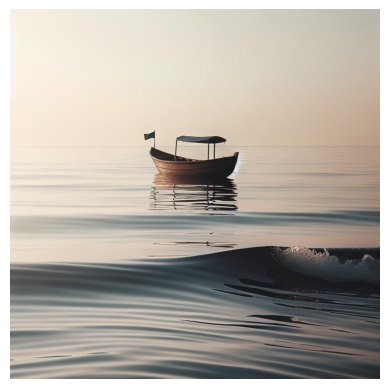

Dalle Assistant Message: /mnt/batch/tasks/shared/LS_root/mounts/clusters/amimukherjee/code/Users/amimukherjee/temp.jpg
Vision Assistant Message: Analyzing the image...
Vision Assistant Message: The image presents a serene and minimalistic composition featuring a solitary wooden boat floating on calm waters. The overall tone is muted and ethereal, conveying a sense of peace and tranquility. The boat, capped with a small canopy and a flag, is perfectly positioned to catch the viewer's focus. The reflection in the water is a nice touch that adds depth to the scene. The light is beautifully managed, likely depicting either dawn or dusk, which gives the scene a dreamy, soft glow.

**Critique:**

1. **Lack of Detail:** While simplicity is part of the image's charm, the boat itself lacks detailed texture or distinctive features. Adding some details or ornaments on the boat could enhance visual interest without disturbing the tranquility.

2. **Foreground Wave:** The wave in the foreground is 

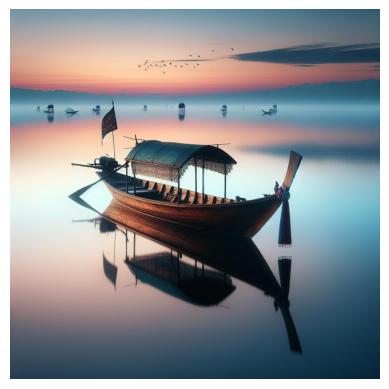

Dalle Assistant Message: /mnt/batch/tasks/shared/LS_root/mounts/clusters/amimukherjee/code/Users/amimukherjee/temp.jpg
Vision Assistant Message: Analyzing the image...
Vision Assistant Message: The image showcases a beautiful and serene landscape capturing a traditional wooden boat on a calm body of water during a picturesque sunrise or sunset. The water is so still that the boat and distant silhouettes of other boats and some kind of structures stand reflected perfectly, enhancing the image's overall tranquility. The warm color palette of the sky with hues of orange and pink transitioning into the blues gives the scene a dreamy and peaceful atmosphere. The thin line of birds flying across the sky adds a dynamic element and conveys a sense of journey and freedom.

Critique:
1. **Details and Texture:** While the overall composition is compelling, the boat’s texture could be enhanced for more realism. Currently, it appears a bit smooth, which could detract from potential wood grain detai

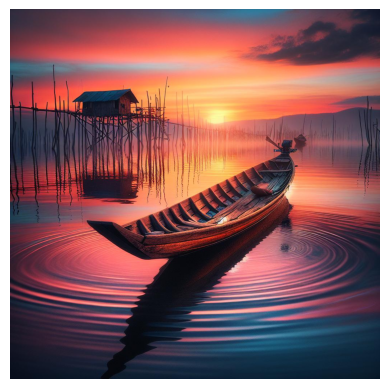

Dalle Assistant Message: /mnt/batch/tasks/shared/LS_root/mounts/clusters/amimukherjee/code/Users/amimukherjee/temp.jpg


In [18]:
thread = assistant_client.beta.threads.create()

# Initiate proxy agent and the main thread. This thread will remain active until the task is completed and will serve as the main communication thread between the other agents.
user_message = input("User Query: ")
message = dispatch_message(user_message, user_proxy, thread)

## Cleaning up
To clean up all Azure Assistant threads.

In [ ]:
response = assistant_client.beta.assistants.delete(user_proxy.id)
response = assistant_client.beta.assistants.delete(dalle_assistant.id)
response = assistant_client.beta.assistants.delete(vision_assistant.id)